# Car Price Prediction

## Machine Learning Regression Algorithm Selection

*Eduardo Solano Jaime*

*0213663*

*ECID*

*Universidad Panamericana campus Guadalajara*

---

### Objective

The following Notebookaims to build a machine learning regression algorithm in order to predict the price of cars based on a the data set [Car Price Prediction(used cars)](https://www.kaggle.com/datasets/vijayaadithyanvg/car-price-predictionused-cars/). Following the checklist provided during class, the proyect will tackle the problem from the begining: including setting the goal of the code, prepare and process the data, feature engineering, odel  building and testing, and final cross validation to determine the optimal method to predict prices.

### Obtain and sample the data

In [35]:
import pandas as pd

dataset = 'car data.csv'
df= pd.read_csv(dataset, sep=',')
names = df.columns
df.sample(3)

,Car_Name,Year,Selling_Price,Present_Price,Driven_kms,Fuel_Type,Selling_type,Transmission,Owner
159,Honda Activa 4G,2017,0.45,0.51,4000,Petrol,Individual,Automatic,0
233,grand i10,2013,3.90,5.70,53000,Diesel,Dealer,Manual,0
14,dzire,2009,2.25,7.21,77427,Petrol,Dealer,Manual,0


### Analysis each feature and its characteristics

In [36]:
print(f'The dataset has a size of {df.shape}')
df.info()

The dataset has a size of (301, 9)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 301 entries, 0 to 300
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Car_Name       301 non-null    object 
 1   Year           301 non-null    int64  
 2   Selling_Price  301 non-null    float64
 3   Present_Price  301 non-null    float64
 4   Driven_kms     301 non-null    int64  
 5   Fuel_Type      301 non-null    object 
 6   Selling_type   301 non-null    object 
 7   Transmission   301 non-null    object 
 8   Owner          301 non-null    int64  
dtypes: float64(2), int64(3), object(4)
memory usage: 21.3+ KB


In [37]:
for name in names:
    print(name, df.loc[:, name].unique()[:min(5, len(df.loc[:, name].unique()))], len(df.loc[:, name].unique()))

Car_Name ['ritz' 'sx4' 'ciaz' 'wagon r' 'swift'] 98
Year [2014 2013 2017 2011 2018] 16
Selling_Price [3.35 4.75 7.25 2.85 4.6 ] 156
Present_Price [5.59 9.54 9.85 4.15 6.87] 148
Driven_kms [27000 43000  6900  5200 42450] 206
Fuel_Type ['Petrol' 'Diesel' 'CNG'] 3
Selling_type ['Dealer' 'Individual'] 2
Transmission ['Manual' 'Automatic'] 2
Owner [0 1 3] 3


We have a total of 8 features + target feature before feature engineering. We can clearly see that some of the columns contain categorical and other numerical data, therefore a preprocessing must be made in order to analyze in depths the dataset to determine wether noise is present and extrat statistical information.

In [38]:
names = df.columns
names

Index(['Car_Name', 'Year', 'Selling_Price', 'Present_Price', 'Driven_kms',
       'Fuel_Type', 'Selling_type', 'Transmission', 'Owner'],
      dtype='object')

Now, before using Pipelines to transform further the date we split it in a 80-20 ratio between test and train. We wont see the test set until the end of the analysis

In [39]:
from sklearn.model_selection import train_test_split

df.columns = [x.replace('_', '') for x in df.columns]
names = df.columns
target = 'PresentPrice'
y = df.loc[:, target]
X = df.loc[:, [x for x in df.columns.values if x!=target]]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_train.sample(3)

,CarName,Year,SellingPrice,Drivenkms,FuelType,Sellingtype,Transmission,Owner
125,Royal Enfield Classic 500,2009,0.90,40000,Petrol,Individual,Manual,0
121,Royal Enfield Thunder 350,2011,1.05,6900,Petrol,Individual,Manual,0
186,TVS Wego,2010,0.25,22000,Petrol,Individual,Automatic,0


### Transform data

For **Categorical data** specific transformations are to be made:
 - Nominal variables
   - *CarName* - LabelEncoder (although I suspect the car name is going to have no correlation with the price)
   - *FuelType* LabelEncoder or OneHotEncoder
   - *Sellingtype* and *Transmission* simple replacement

For **Numerical data** a simple StandardScaler is going to be used since there are no missing values

In [40]:
# Numerical data
numeric = ['Year', 'SellingPrice', 'Drivenkms']

# Binary cata
binary = ['Sellingtype', 'Transmission']

# Easy binary replacements for binary columns
X_train[binary] = df.loc[:, binary].replace({'Dealer':0,  'Individual':1, 'Manual':0, 'Automatic':1})
X_test[binary] = df.loc[:, binary].replace({'Dealer':0,  'Individual':1, 'Manual':0, 'Automatic':1})

X_train.sample(3)

,CarName,Year,SellingPrice,Drivenkms,FuelType,Sellingtype,Transmission,Owner
261,brio,2016,5.50,5600,Petrol,0,0,0
163,Bajaj Avenger 220 dtsi,2010,0.45,27000,Petrol,1,0,0
279,city,2014,6.25,40126,Petrol,0,0,0


In [41]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from category_encoders import BinaryEncoder, OneHotEncoder

# dummy = FunctionTransformer(lambda x: pd.get_dummies(x, drop_first=True), validate=False)

ct = ColumnTransformer(transformers=
                       [('numeric', StandardScaler(), numeric),
                        ('cars', BinaryEncoder(), ['CarName']),
                        ('fuel', OrdinalEncoder(), ['FuelType'])],
                       remainder='passthrough')

X_train_fit = ct.fit_transform(X_train)
columns = numeric + [x for x in list(ct.get_feature_names_out()[3:-4])] + ['FuelType', 'Sellingtype', 'Transmission', 'Owner']
X_train_fit = pd.DataFrame(X_train_fit, columns=columns) # type: ignore
X_test_fit = ct.fit_transform(X_test)
columns = numeric + [x for x in list(ct.get_feature_names_out()[3:-4])] + ['FuelType', 'Sellingtype', 'Transmission', 'Owner']
X_test_fit = pd.DataFrame(X_test_fit, columns=columns) # type: ignore
X_train_fit.sample(5)

,Year,SellingPrice,Drivenkms,cars__CarName_0,cars__CarName_1,cars__CarName_2,cars__CarName_3,cars__CarName_4,cars__CarName_5,cars__CarName_6,FuelType,Sellingtype,Transmission,Owner
187,0.477365,-0.717065,-0.795739,0.0,0.0,1.0,0.0,1.0,1.0,0.0,2.0,1.0,0.0,0.0
150,-1.867586,-0.874721,-0.354759,1.0,0.0,0.0,0.0,0.0,1.0,1.0,2.0,1.0,0.0,1.0
78,-0.192621,0.182502,0.490452,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
208,-2.872565,-0.883995,0.710942,1.0,0.0,0.0,1.0,1.0,0.0,1.0,2.0,1.0,0.0,0.0
132,0.812358,-0.383205,-0.850861,0.0,0.0,1.0,0.0,1.0,0.0,1.0,2.0,0.0,0.0,0.0


# DUDAS

¿Porque no funciona OneHotEncoder ni LabelEncoder?

¿Como puedo estandarizar por columna?

### Extra features

I theorize that the relationship between the year the car was sold and how many kilometers weights heavily. I am adding an extra feature to relate them

In [42]:
X_train_fit['WellKept'] = X_train_fit.loc[:, 'Drivenkms'] * X_train_fit.loc[:, 'Year'] # type: ignore
X_test_fit['WellKept'] = X_test_fit.loc[:, 'Drivenkms'] * X_test_fit.loc[:, 'Year'] # type: ignore

### Correlation Matrix

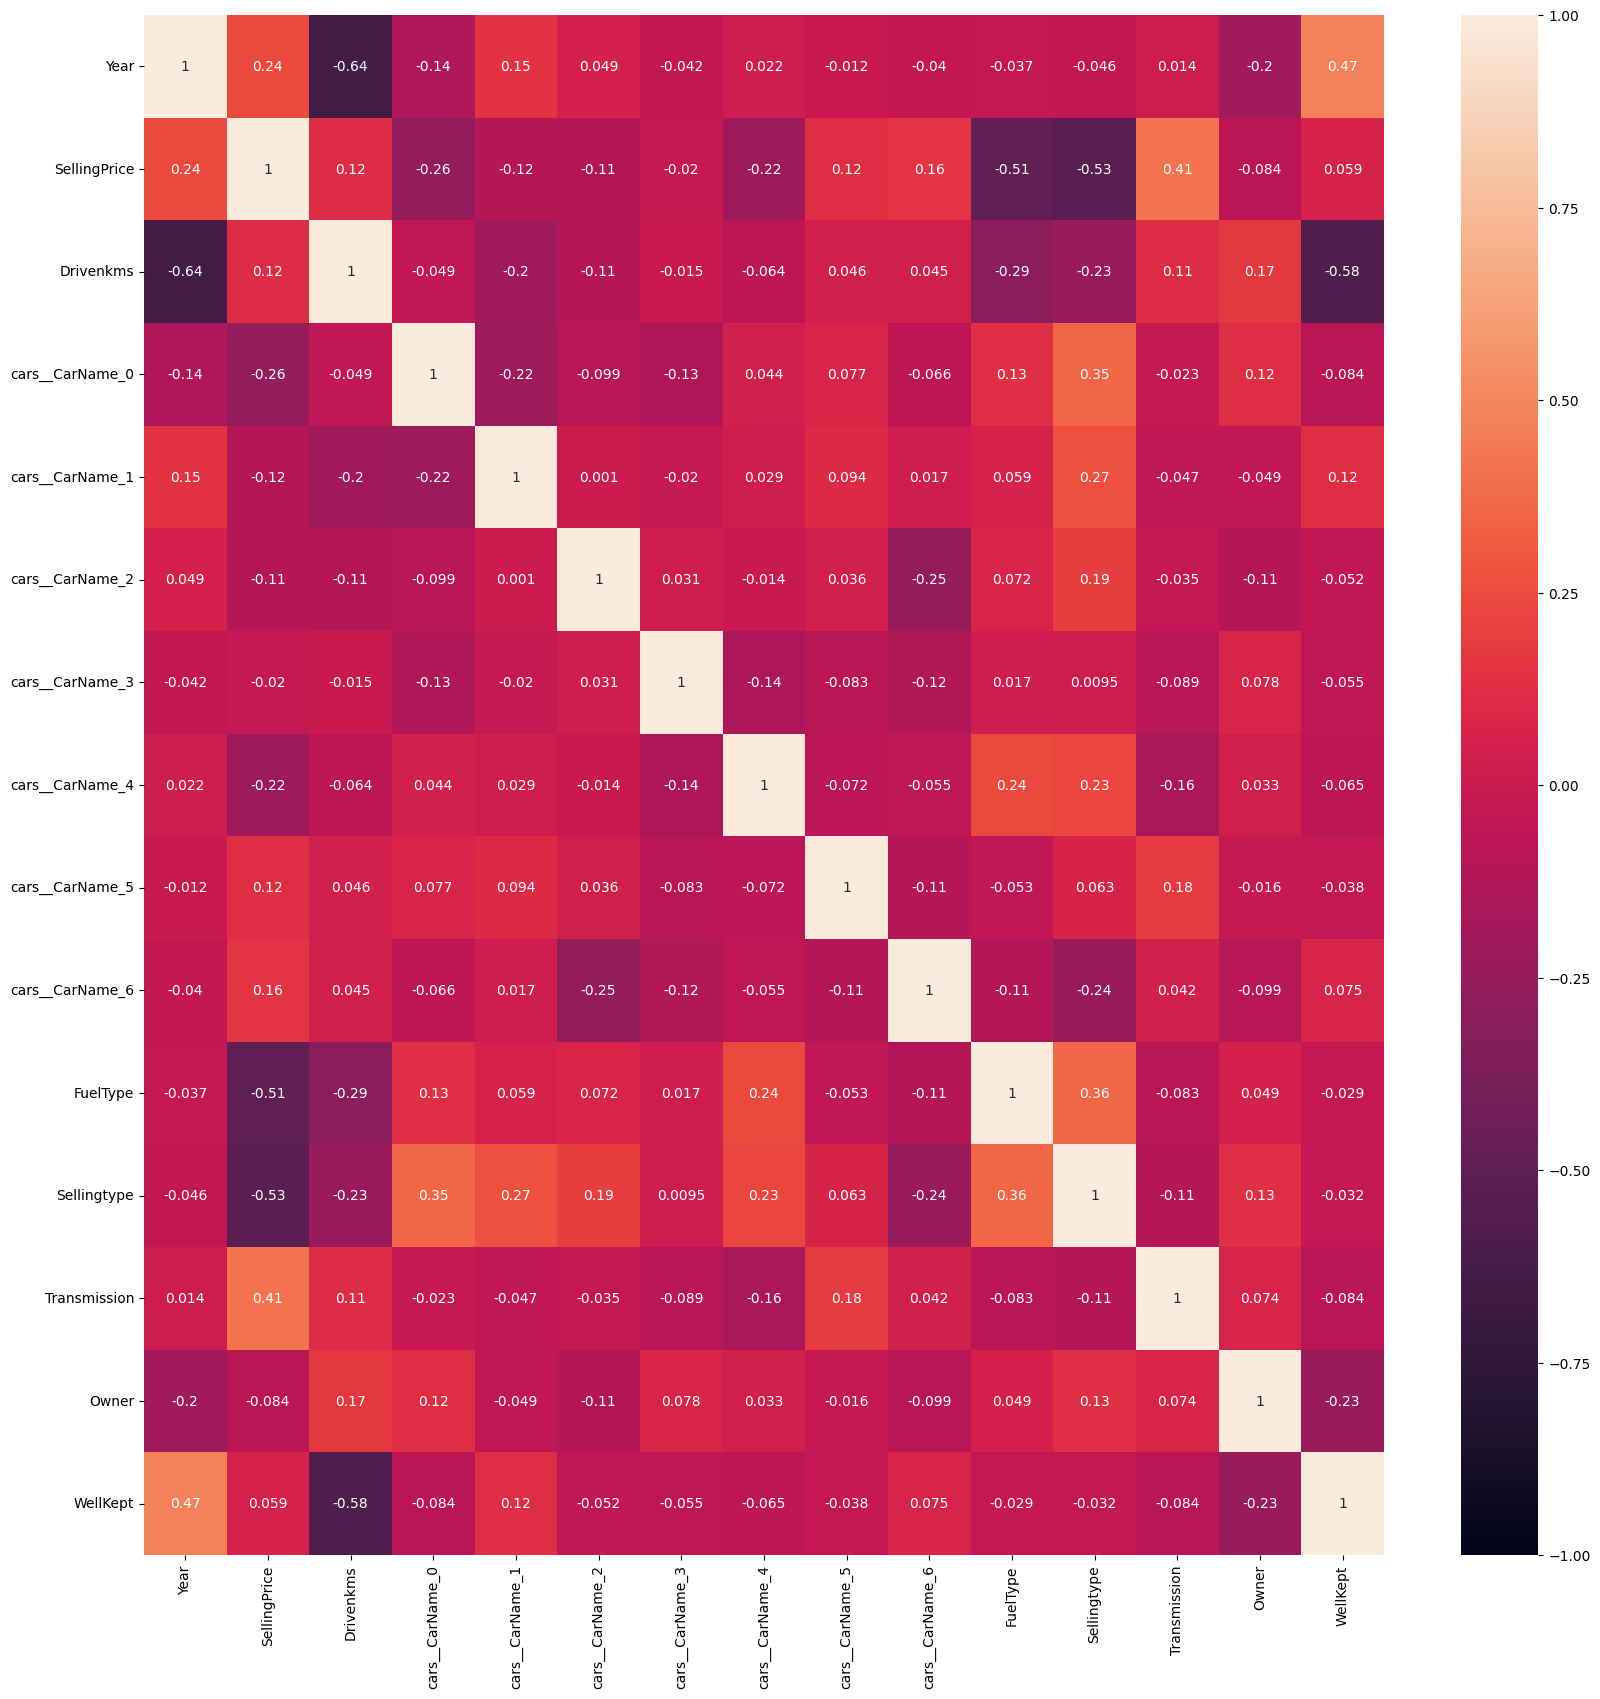

In [43]:
import matplotlib.pyplot as plt
import seaborn as sea

correlation = X_train_fit.corr(method='pearson')
fig1 = plt.figure(figsize=(20,20))
ax = sea.heatmap(correlation, annot=True, vmin=-1, vmax=1)
plt.show()

There are no positively correlated features, so we can begin with the model training without any more feature engineering.

### Shortlist Promising Models

In [44]:
# Get the models

from sklearn.linear_model import LinearRegression, Ridge, Lasso, SGDRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import BayesianRidge
from sklearn.gaussian_process import GaussianProcessRegressor
import xgboost as xgb

models = [LinearRegression(), PolynomialFeatures(), Ridge(), Lasso(), DecisionTreeRegressor(),
          RandomForestRegressor(), SGDRegressor(), KNeighborsRegressor(), BayesianRidge()]

xgb.set_config(verbosity=0)

In [45]:
for model in models:
    score = 0
    if str(model)=='PolynomialFeatures()':
        model = LinearRegression()
        poly_features = PolynomialFeatures()
        X_poly = poly_features.fit_transform(X_train_fit)
        model.fit(X_poly, y_train)
        score = model.score(X_poly, y_train)
        model = PolynomialFeatures()
    else:
        model.fit(X_train_fit, y_train)
        score = model.score(X_train_fit, y_train)
    print(f"Score of {score:.5f} was achieved with {model}")

Score of 0.87399 was achieved with LinearRegression()
Score of 0.99092 was achieved with PolynomialFeatures()
Score of 0.87392 was achieved with Ridge()
Score of 0.82809 was achieved with Lasso()
Score of 1.00000 was achieved with DecisionTreeRegressor()
Score of 0.96377 was achieved with RandomForestRegressor()
Score of 0.87130 was achieved with SGDRegressor()
Score of 0.83812 was achieved with KNeighborsRegressor()
Score of 0.87376 was achieved with BayesianRidge()


Before jumping to any conclusions about the performance of the models, I want to try a different feature engineering in which the *model* column goes through a OneHotEncoder, I suspect there are some specific model that are a hot-sell.

In [46]:
ct2 = ColumnTransformer(transformers=
                       [('numeric', StandardScaler(), numeric),
                        ('cars', OneHotEncoder(), ['CarName']),
                        ('fuel', OrdinalEncoder(), ['FuelType'])],
                       remainder='passthrough')

X_train_fit = ct.fit_transform(X_train)
columns = numeric + [x for x in list(ct.get_feature_names_out()[3:-4])] + ['FuelType', 'Sellingtype', 'Transmission', 'Owner']
X_train_fit = pd.DataFrame(X_train_fit, columns=columns) # type: ignore
X_test_fit = ct.fit_transform(X_test)
columns = numeric + [x for x in list(ct.get_feature_names_out()[3:-4])] + ['FuelType', 'Sellingtype', 'Transmission', 'Owner']
X_test_fit = pd.DataFrame(X_test_fit, columns=columns) # type: ignore

for model in models:
    if str(model)=='PolynomialFeatures()':
        model = LinearRegression()
        poly_features = PolynomialFeatures(degree=2)
        X_poly = poly_features.fit_transform(X_train_fit)
        model.fit(X_poly, y_train)
        model.score(X_poly, y_train)
        model = PolynomialFeatures()
    else:
        model.fit(X_train_fit, y_train)
        score = model.score(X_train_fit, y_train)
    print(f"Score of {score:.5f} was achieved with {model}")

Score of 0.87316 was achieved with LinearRegression()
Score of 0.87316 was achieved with PolynomialFeatures()
Score of 0.87310 was achieved with Ridge()
Score of 0.82809 was achieved with Lasso()
Score of 1.00000 was achieved with DecisionTreeRegressor()
Score of 0.96716 was achieved with RandomForestRegressor()
Score of 0.87138 was achieved with SGDRegressor()
Score of 0.84114 was achieved with KNeighborsRegressor()
Score of 0.87297 was achieved with BayesianRidge()


The results of the different models suggest that the change in the transformer provides more information and performs better.

Now we can pick our top 3 candidate, and according to their scores:
1. **DecisionTreeRegressor()**
2. **PolynomialFeatures()()**
3. **BayesianRidge()**

Now, feature engineering is needed to remove higly correlated features

In [47]:
import numpy as np

corr = X_train_fit.corr().abs() # type: ignore
up = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
to_drop = [column for column in up.columns if any(up[column] > 0.7)]
X_train_fit.drop(to_drop, axis=1, inplace=True) # type: ignore
X_train_fit.shape

(240, 14)

Identify the most important features of each model.

In [48]:
tree = DecisionTreeRegressor()
tree_m = tree.fit(X_train_fit, y_train)

poly_m = PolynomialFeatures(degree=2)
X_poly = poly_m.fit_transform(X_train_fit)
poly = LinearRegression().fit(X_poly, y_train)

bayesian = BayesianRidge()
bayesian_m = bayesian.fit(X_train_fit, y_train) # type: ignore

print(f"Tree: {[list(X_train_fit.columns)[i] for i in np.argsort(tree_m.feature_importances_)[::-1][:5]]}") # type: ignore
print(f"Polynomial: {[poly_m.get_feature_names_out()[i] for i in np.argsort(poly.coef_)[::-1][:5]]}")
print(f"Bayesian: {[list(X_train_fit.columns)[i] for i in np.argsort(bayesian_m.feature_names_in_)[::-1][:5]]}") # type: ignore

Tree: ['SellingPrice', 'cars__CarName_1', 'Drivenkms', 'cars__CarName_5', 'Year']
Polynomial: ['cars__CarName_5', 'cars__CarName_6', 'FuelType Owner', 'cars__CarName_3^2', 'Drivenkms Owner']
Bayesian: ['cars__CarName_6', 'cars__CarName_5', 'cars__CarName_4', 'cars__CarName_3', 'cars__CarName_2']


### Fine-Tune the models

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold

repeatedkfold = RepeatedKFold(n_splits=10, n_repeats=20)

param_grids = [
    {'criterion': ['absolute_error', 'squared_error', 'friedman_mse'],  # DecisionTree
    'max_depth': [None, 5, 10, 20, 30, 40, 50],
    'min_samples_split': [i for i in range(2, 11)],
    'min_samples_leaf': [1, 2, 4],},
    {'polynomialfeatures__degree': [1, 2, 3]},                        # Polynomial Regression
    {'alpha_1': [1e-6, 1e-5, 1e-4, 1e-3, 1e-2],                         # Bayesian Ridge
    'alpha_2': [1e-6, 1e-5, 1e-4, 1e-3, 1e-2],
    'lambda_1': [1e-6, 1e-5, 1e-4, 1e-3, 1e-2],
    'lambda_2': [1e-6, 1e-5, 1e-4, 1e-3, 1e-2]}
    ]

regressors = [tree, poly, bayesian]

for regressor, param_grid in zip(regressors, param_grids):
    if str(regressor) == 'LinearRegression()':
        pipeline = Pipeline([
                            ('polynomialfeatures', PolynomialFeatures()),
                            ('linearregression', LinearRegression())
                        ])
        grid_search = GridSearchCV(pipeline, param_grid, cv=5)
        grid_search.fit(X_train_fit, y_train)
    else:
        grid_search = GridSearchCV(regressor, param_grid, cv=5)
        grid_search.fit(X_train_fit, y_train)
    print(f"{regressor}: {grid_search.best_estimator_}")
    print(f"Best params: {grid_search.best_params_}")
    result = cross_val_score(model, X_test_fit, y_test, cv=repeatedkfold)
    print(f"Accuracy: {result.mean()*100:,.2f}%, std {result.std():,.2f}")
    print()


In [ ]:
grid_search.cv_results_.keys()